Import stuff and initialize global parameters.

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Flatten, Dense, LSTM, \
    MaxPooling2D
from keras.models import Sequential
from common import extract_training_data

IMAGE_SIZE = (64, 64, 3)

Using TensorFlow backend.


# LSTM network
Reading data and creating initial model.

In [2]:
images, labels = extract_training_data("Data/20171029-201949.h264.avi", "Data/20171029-201949.h264.csv", IMAGE_SIZE)

In [3]:
y_train = labels.as_matrix(columns=labels.columns[1: -1])
y_train.shape

(1744, 3)

In [4]:
images.shape

(1744, 64, 64, 3)

In [5]:
from keras.layers import Permute, Reshape

def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Permute((3, 2, 1)))
    model.add(Reshape((4, 7688)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(3, activation='linear'))

    model.compile(loss="mse", optimizer="adam")
    
    return model

model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
permute_1 (Permute)          (None, 32, 31, 31)        0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 7688)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                1984768   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,985,859
Trainable params: 1,985,859
Non-trainable params: 0
_________________________________________________________________


### LSTM network results

In [6]:
history = model.fit(images, y_train, batch_size=64, epochs=10, validation_split=0.04)

Train on 1674 samples, validate on 70 samples
Epoch 1/10
1674/1674 [==============================] - 3s - loss: 0.3055 - val_loss: 0.2688
Epoch 2/10
1674/1674 [==============================] - 0s - loss: 0.0895 - val_loss: 0.2594
Epoch 3/10
1674/1674 [==============================] - 0s - loss: 0.0780 - val_loss: 0.2760
Epoch 4/10
1674/1674 [==============================] - 0s - loss: 0.0707 - val_loss: 0.2624
Epoch 5/10
1674/1674 [==============================] - 0s - loss: 0.0663 - val_loss: 0.2760
Epoch 6/10
1674/1674 [==============================] - 0s - loss: 0.0613 - val_loss: 0.2769
Epoch 7/10
1674/1674 [==============================] - 0s - loss: 0.0576 - val_loss: 0.2808
Epoch 8/10
1674/1674 [==============================] - 0s - loss: 0.0556 - val_loss: 0.2780
Epoch 9/10
1674/1674 [==============================] - 0s - loss: 0.0543 - val_loss: 0.2779
Epoch 10/10
1674/1674 [==============================] - 0s - loss: 0.0497 - val_loss: 0.2891


In [7]:
test_images, test_labels = extract_training_data("Data/20171029-201639.h264.avi", 
                                                            "Data/20171029-201639.h264.csv", 
                                                            IMAGE_SIZE)

prediction = model.predict(test_images)

In [8]:
prediction

array([[ 0.33686137,  0.12799484,  0.95844716],
       [ 0.37755403,  0.10497643,  0.94694453],
       [ 0.35190707,  0.11263372,  0.95089626],
       ..., 
       [-0.35214299,  0.00862575,  0.98164457],
       [-0.32364139, -0.03065464,  1.00149977],
       [-0.23717432,  0.03360973,  0.98100537]], dtype=float32)

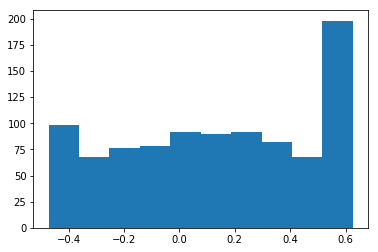

In [9]:
plt.hist(prediction[:, 0])
plt.show()

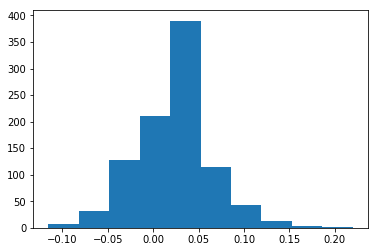

In [10]:
plt.hist(prediction[:, 1])
plt.show()

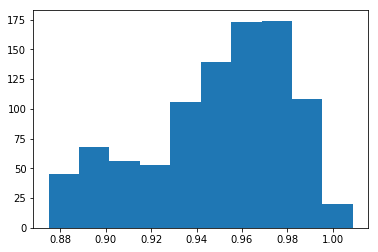

In [11]:
plt.hist(prediction[:, 2])
plt.show()

In [12]:
validation_labels = test_labels.as_matrix(columns=test_labels.columns[1: -1])
clipped_prediction = np.zeros_like(prediction)

clipped_prediction[:, 0] = np.clip(prediction[:, 0], -1, 1)
clipped_prediction[:, 1] = np.clip(prediction[:, 1], 0, 1)
clipped_prediction[:, 2] = np.clip(prediction[:, 2], 0, 1)

print(validation_labels.shape)
print(clipped_prediction.shape)

(942, 3)
(942, 3)


In [13]:
from sklearn.metrics import explained_variance_score
explained_variance_score(validation_labels, prediction)

0.1108657072559897

## K fold cross validation

Currently the model is just a copy of what is above, defined as a function for the KerasRegressor wrapper

In [16]:
from common import run_kfold_cross_val

# Concatenate both videos
total_images = np.concatenate((images, test_images), axis=0)
total_labels = np.concatenate((labels, test_labels), axis=0)

total_y_train = total_labels[:, 1:-1]

results = run_kfold_cross_val(create_model, total_images, total_y_train)
print(results)
print(results.mean())
print(np.median(results))

[-0.1026516   0.04183956  0.18578287  0.29401657  0.00615382  0.17690809
  0.16321612  0.21082882  0.08599226  0.066355  ]
0.112844150141
0.124604190153
